<h1><center>Segmentacion de imagenes: Metodo de conjunto de nivel</center></h1>
<center><strong>Análisis Numérico de Ecuaciones en Derivadas Parciales:Teoría y Laboratorio</strong></center>
<center>Autores: Felipe Urrutia, Daniel Minaya, Sebastian Toloza</center>
<center>Tutor: Axel Osses A., Auxiliar: Emir N. Chacra</center>

# Primeros resultados

Estudio del conjunto de imagenes de los Problemas de Bongard

In [1]:
from class_levelsetmethod import LevelSetMethod, Image, np, plt, animation, os

In [2]:
arr = os.listdir("dataset/dataset_bp")
print(arr)

['BP001_10.jpg', 'BP012_8.jpg', 'BP016_6.jpg', 'BP029_10.jpg', 'BP042_3.jpg', 'BP042_3_c.png', 'BP063_0.jpg', 'BP071_10.jpg', 'BP097_10.jpg', 'BP097_11.jpg', 'BP097_5.jpg', 'BP097_9.jpg', 'BP098_2.jpg']


Wall time: 28 ms


Text(0.5, 1.0, 'BP097_11')

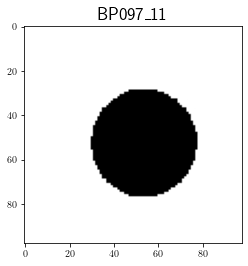

In [5]:
%%time
id_name="BP097_11"
img_o = Image.open(f"dataset/dataset_bp/{id_name}.jpg")

dim = (img_o.size[1], img_o.size[0])
img = np.array(img_o.getdata()).reshape((dim[0], dim[1]))

plt.imshow(img, cmap="gray")
plt.title(id_name, size=18);

<set_image> img: <class 'numpy.ndarray'>, reshape: True, norm: True
|img_dim:     [98 98]
|img_min/max: (0, 255)
|new_img_min/max(norm): (0, 255)
|size_domain: 9604
</set_image>
Wall time: 79.9 ms


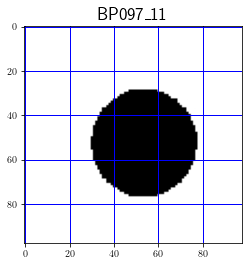

In [7]:
%%time
segmentator = LevelSetMethod(id_name=id_name)
segmentator.set_image(
    img, 
    reshape=True,
    norm=True
)
segmentator.show_image(grid=True)

Wall time: 261 ms


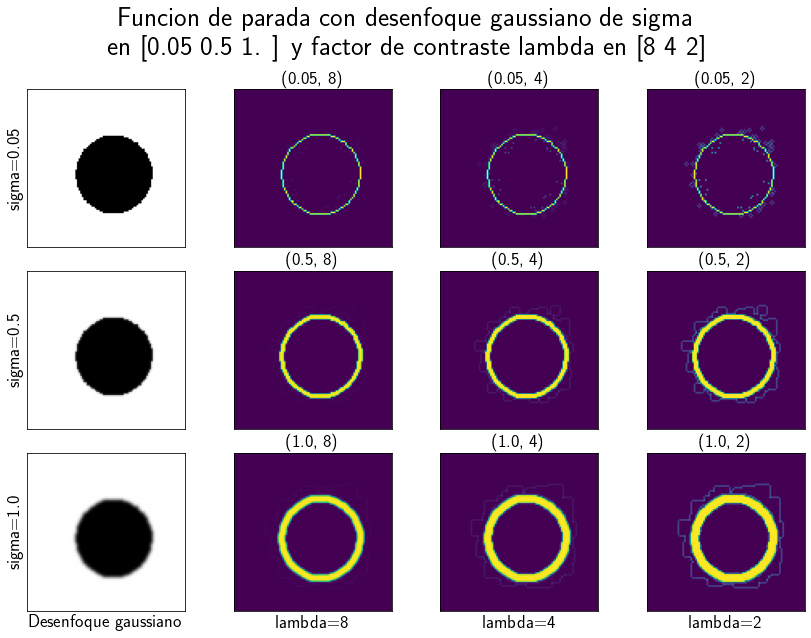

In [8]:
%%time
segmentator.eval_stopfunct(
    list_sgm=np.array([0.05, 0.5, 1]), 
    list_lmbd=np.array([8, 4, 2]),
    cmap="viridis_r"
)

In [9]:
%%time
segmentator.set_stopfunct(
    sgm=0.05, 
    lmbd=8,
)

<set_stopfunct> sigma: 0.05, lambda: 8
|gauss_min/max: (0, 255)
|stopfunct_min/max:     (0.0004918687939992007, 1.0)
</set_stopfunct>
Wall time: 3.99 ms


Wall time: 36 ms


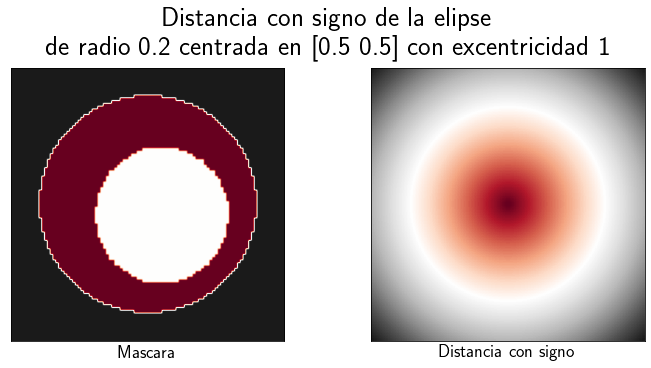

In [11]:
%%time
segmentator.eval_sgndist(
    c=np.array([0.5, 0.5]), 
    r=0.2,
    e=1
)

In [12]:
%%time
segmentator.set_sgndist(
    c=np.array([0.5, 0.5]), 
    r=0.2,
    e=1
)

<set_sgndist> centro: [0.5 0.5], radio: 0.2, excentricidad: 1
</set_sgndist>
Wall time: 0 ns


Wall time: 79.9 ms


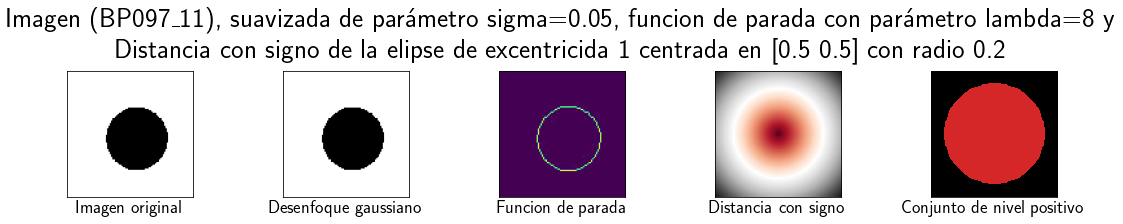

In [13]:
%%time 
segmentator.show_setting(cmap_stopfunct="viridis_r")

In [14]:
%%time 
segmentator.print_setting()

<print_setting>
|sigma: 0.05
|lambda: 8
|centro: [0.5 0.5]
|radio: 0.2
|excentricidad: 1
</print_setting>
Wall time: 0 ns


In [15]:
%%time
segmentator.solve(
    n_iter = 50,
    tau = 0.25,
    k = -2,
    save_rate=10,
    root_path_save="results",
    show_log_rate=5
)

<solve> N° iteraciones: 50, discretizacion en tiempo: 0.25, constante k: -2
|path_save_file: results/BP097_11__iterations_times__sgm_0_05__lmbd_8__cx_0_5__cy_0_5__r_0_2__e_1__tau_0_25__k_-2
|Iter: 1, T iter: 3.9s, T trans:  7.7s, T per iter: 3.8s p/m  0.1s, T rest:  191.6s p/m  0.5s
|Iter: 6, T iter: 4.2s, T trans:  26.7s, T per iter: 3.8s p/m  0.2s, T rest:  171.9s p/m  1.3s
|Iter: 11, T iter: 3.9s, T trans:  47.3s, T per iter: 3.9s p/m  0.3s, T rest:  157.5s p/m  1.7s
|Iter: 16, T iter: 3.8s, T trans:  66.8s, T per iter: 3.9s p/m  0.2s, T rest:  137.5s p/m  1.3s
|Iter: 21, T iter: 3.8s, T trans:  86.2s, T per iter: 3.9s p/m  0.2s, T rest:  117.5s p/m  1.1s
|Iter: 26, T iter: 4.2s, T trans:  105.9s, T per iter: 3.9s p/m  0.2s, T rest:  98.1s p/m  1.0s
|Iter: 31, T iter: 3.4s, T trans:  124.3s, T per iter: 3.9s p/m  0.2s, T rest:  77.7s p/m  1.0s
|Iter: 36, T iter: 3.4s, T trans:  142.9s, T per iter: 3.9s p/m  0.3s, T rest:  57.9s p/m  1.0s
|Iter: 41, T iter: 3.8s, T trans:  161.8s, T 

Wall time: 1.35 s


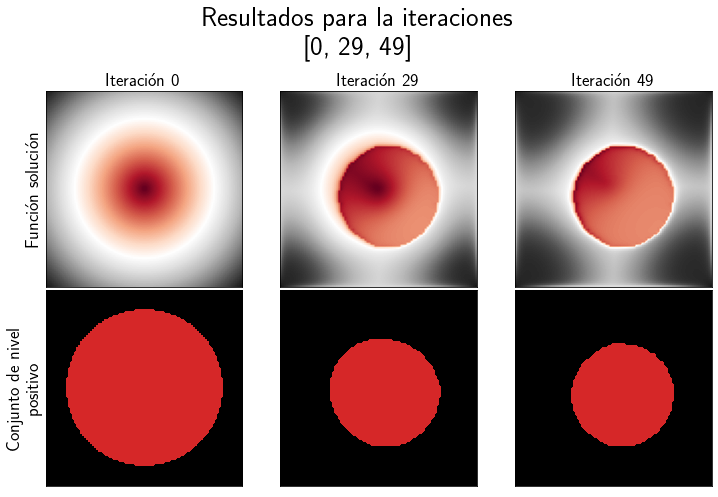

In [16]:
%%time
segmentator.show_solution(
    show_iters=[0, 29, 49]
)

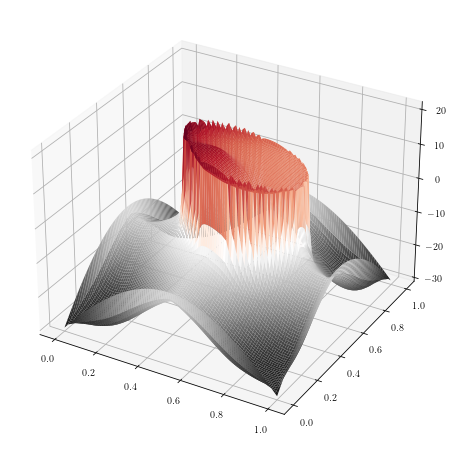

In [18]:
fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, 1, segmentator.dim[0])
y = np.linspace(0, 1, segmentator.dim[1])
xx, yy = np.meshgrid(x, y)
zz = segmentator.iterations[49]
z = np.ravel(zz)
# ax.scatter(xx, yy, z, c=z, cmap='viridis', linewidth=0.5);
# ax.plot_trisurf(np.ravel(xx), np.ravel(yy), z, cmap='RdGy_r', linewidth=1);
ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, 
                cmap='RdGy_r', edgecolor='none');

MovieWriter ffmpeg unavailable; using Pillow instead.


Wall time: 49.7 s


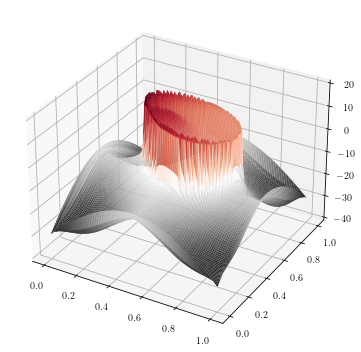

In [20]:
%%time
fps = 250
frn = 50

x = np.linspace(0, 1, segmentator.dim[0])
y = np.linspace(0, 1, segmentator.dim[1])
xx, yy = np.meshgrid(x, y)

zarray = np.zeros((segmentator.dim[0], segmentator.dim[1], frn))

for i in range(frn):
    zarray[:, :, i] = segmentator.iterations[i]

def change_plot(frame_number, zarray, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, zarray[:, :, frame_number], rstride=1, cstride=1, 
                cmap='RdGy_r', edgecolor='none')

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(xx, yy, zarray[:, :, 0], rstride=1, cstride=1, 
                cmap='RdGy_r', edgecolor='none')]
plt.tight_layout()
ax.set_zlim(-40, 20)
ani = animation.FuncAnimation(fig, change_plot, frn, fargs=(zarray, plot), interval=1000 / fps)

# ax.axis('off')

ani.save(f'{id_name}.gif');

<img src="matplot003.gif">